# Tree methods additional notes
* Additional notes on tree based methods
* Special *tricky* example
* Tries to fool classification

In [2]:
%matplotlib inline

# Load files from introML
import sys
import os
targetDirectory = os.path.abspath("../../introML/")
sys.path.append(targetDirectory)

import matplotlib.pyplot as plt
import numpy as np
import mglearn
# import graphviz
from sklearn.model_selection import train_test_split

# cross validation machinery
# These are some new scikit learn toys that will make your life easier (see below)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings("ignore")

### Remember our old two mean/class data set
* Generate blobs of data 
* Distributed around two differet means

In [3]:
# generate points around two different means
# classify these as zero or one
# scramble the data
def make_gclass(n,mu1,mu2):
    x1 = np.random.normal(size=(n,2),loc=mu1,scale=1.)
    x2 = np.random.normal(size=(n,2),loc=mu2,scale=1.)
    y1 = np.zeros(n)
    y2 = np.ones(n)
    Xsource = np.append(x1,x2,axis=0)
    Ysource = np.append(y1,y2)
    scramIndex = np.random.randint(low=0,high=2*n,size=n)
    X = Xsource[scramIndex]
    Y = Ysource[scramIndex]
    return X,Y

### Augment to make the problem trickier
* Now flip a coin at each point
* Record 0 or 1
* If coin is 1, then flip classification

In [4]:
# generate points around two different means
# classify these as zero or one
# scramble the data
def make_gclassTricky(n,mu1,mu2):
    x1 = np.random.normal(size=(n,2),loc=mu1,scale=1.)
    x2 = np.random.normal(size=(n,2),loc=mu2,scale=1.)
    x3 = np.random.randint(size=(2*n,1),low=0,high=2)
    # x3 forecast variable is small (on either side of zero)
    # This is to confuse nearest neighbor systems
    x3flt = 0.01*(x3[:,0]==1) + -0.01*(x3[:,0]==0)
    x3flt = x3flt.reshape((2*n,1))
    y1 = -1*np.ones(n)
    y2 = np.ones(n)
    Xsource1 = np.append(x1,x2,axis=0)
    Xsource  = np.append(Xsource1,x3flt,axis=1)
    Ysource = np.append(y1,y2)
    # When X3=1 then reverse the class
    Ysource[x3[:,0]==1] = -1 * Ysource[x3[:,0]==1]
    scramIndex = np.random.randint(low=0,high=2*n,size=n)
    X = Xsource[scramIndex]
    Y = Ysource[scramIndex]
    return X,Y

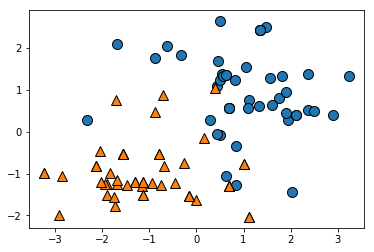

In [5]:
# quick demo of our old data generator
X,y = make_gclass(100,1.,-1.)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

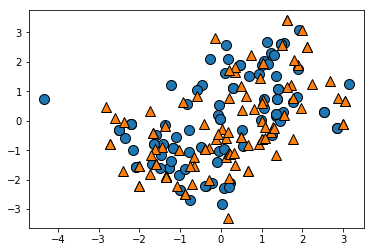

In [6]:
# Now, the new data generator
X,y = make_gclassTricky(200,1.,-1.)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# In (x0,X1) space, data is all jumbled

[-0.01  0.01 -0.01 -0.01 -0.01 -0.01 -0.01  0.01  0.01  0.01 -0.01 -0.01
  0.01  0.01 -0.01  0.01 -0.01 -0.01  0.01  0.01  0.01  0.01 -0.01  0.01
 -0.01 -0.01  0.01  0.01 -0.01  0.01 -0.01 -0.01  0.01 -0.01  0.01  0.01
  0.01 -0.01 -0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01 -0.01  0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01 -0.01 -0.01  0.01
 -0.01  0.01  0.01  0.01 -0.01  0.01 -0.01 -0.01 -0.01  0.01 -0.01  0.01
  0.01  0.01  0.01 -0.01 -0.01  0.01  0.01 -0.01 -0.01 -0.01  0.01 -0.01
  0.01  0.01  0.01 -0.01 -0.01 -0.01 -0.01  0.01 -0.01 -0.01 -0.01 -0.01
 -0.01  0.01  0.01  0.01  0.01  0.01  0.01 -0.01 -0.01 -0.01 -0.01  0.01
 -0.01  0.01 -0.01 -0.01  0.01  0.01  0.01  0.01 -0.01 -0.01 -0.01 -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01  0.01 -0.01 -0.01 -0.01 -0.01  0.01  0.01
 -0.01  0.01  0.01 -0.01  0.01  0.01 -0.01 -0.01  0.01  0.01  0.01  0.01
 -0.01 -0.01 -0.01 -0.01 -0.01  0.01 -0.01  0.01  0.01  0.01 -0.01  0.01
  0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0

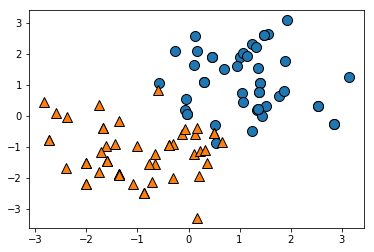

In [7]:
# We can graphically slice by our X2 variable
#  (Since we know what is going on!)
mglearn.discrete_scatter(X[X[:,2]<0., 0], X[X[:,2]<0., 1], y[X[:,2]<0.])
print(X[:,2])

### cross_val_score()
* Automatic test/train random simulation
* Does what we have done with for loops automatically
* Generates vector of simulated test set scores
* One problem:  No training scores
* See how to call it in code below

In [6]:
# Let's try a linear separation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
# Set up train/test simulation and store in cvf
cvf = ShuffleSplit(n_splits=25, test_size=0.25)
# Simuate scores:  returns vector, note cv argument
scores = cross_val_score(lda, X, y, cv=cvf)
print(np.mean(scores))

0.42160000000000003


In [7]:
# Now fire up a tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=5)
cvf = ShuffleSplit(n_splits=25, test_size=0.25)
scores = cross_val_score(tree, X, y, cv=cvf)
print(np.mean(scores))

0.8768


## K Nearest neighbor for fun

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=11)
cvf = ShuffleSplit(n_splits=25, test_size=0.25)
scores = cross_val_score(knn, X, y, cv=cvf)
print(np.mean(scores))

0.5184


## Time for the mighty **random forest**

In [9]:
# now a random Forecast
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=250,max_features=3,max_depth=5)
cvf = ShuffleSplit(n_splits=25, test_size=0.25)
scores = cross_val_score(forest, X, y, cv=cvf)
print(np.mean(scores))

0.9192


# Boosting classifiers

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
# default = (100, 3, 0.1)
gbrt = GradientBoostingClassifier(n_estimators=40,max_depth=2,learning_rate=0.1)
cvf = ShuffleSplit(n_splits=25, test_size=0.25)
scores = cross_val_score(gbrt, X, y, cv=cvf)
print(np.mean(scores))

0.8664000000000001
